In [37]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib notebook
import sys
sys.setrecursionlimit(2000)

In [38]:
G = 0.1
theta = 0.5
dt = 0.005
num_bodies = 5
epsilon = 0.1

def distance(bod1, bod2):
    x1, y1, z1 = bod1.px, bod1.py, bod1.pz
    x2, y2, z2 = bod2.px, bod2.py, bod2.pz
    return ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)**0.5

def force(bod1, bod2):
    m1 = bod1.mass
    m2 = bod2.mass
    return G*m1*m2/distance(bod1,bod2)**2

def x_component(bod1, bod2):
    return (bod1.px-bod2.px)/(distance(bod1, bod2)+epsilon)

def y_component(bod1, bod2):
    return (bod1.py-bod2.py)/(distance(bod1, bod2)+epsilon)

def z_component(bod1, bod2):
    return (bod1.pz-bod2.pz)/(distance(bod1, bod2)+epsilon)

In [39]:
class Body:
    def __init__(self, mass, px, py, pz, vx, vy, vz):
        self.mass = mass
        self.px = px
        self.py = py
        self.pz = pz
        self.vx = vx
        self.vy = vy
        self.vz = vz
        self.fx = 0
        self.fy = 0
        self.fz = 0
    
    def zero_forces(self, by_root = False):
        if by_root:
            self.fx = 0
            self.fy = 0
            self.fz = 0

class Node:
    def __init__(self, xleft, xright, ybot, ytop, zfront, zback):
        # Initialize an empty node, meaning a region in space but no bodies in it and no children
        
        # Define the children and domain. zback > zfront
        #front
        self.topleft, self.topright, self.botleft, self.botright = None, None, None, None
        #back
        self.topleftb, self.toprightb, self.botleftb, self.botrightb = None, None, None, None
        self.xleft, self.xright, self.ybot, self.ytop, self.zfront, self.zback = xleft, xright, ybot, ytop, zfront, zback
        self.centerx = (xleft+xright)/2
        self.centery = (ybot+ytop)/2
        self.centerz = (zfront+zback)/2
        
        # Define the Center of Mass and total Mass
        self.CoMx, self.CoMy, self.CoMz, self.totM = None, None, None, 0
        
        # Define
        self.body = None
        
    def which_child(self, x, y, z):
        assert x< self.xright and x > self.xleft and y < self.ytop and y > self.ybot and z > self.zfront and z < self.zback, "Must be in Rect"
        if x >= self.centerx and y >= self.centery and z < self.centerz: ## front
            return self.topright
        elif x >= self.centerx and y < self.centery and z < self.centerz:
            return self.botright
        elif x < self.centerx and y >= self.centery and z < self.centerz:
            return self.topleft
        elif x < self.centerx and y < self.centery and z < self.centerz:
            return self.botleft
        elif x >= self.centerx and y >= self.centery and z >= self.centerz: ## back
            return self.toprightb
        elif x >= self.centerx and y < self.centery and z >= self.centerz:
            return self.botrightb
        elif x < self.centerx and y >= self.centery and z >= self.centerz:
            return self.topleftb
        elif x < self.centerx and y < self.centery and z >= self.centerz:
            return self.botleftb
        else:
            return None

        
    def add_body(self, new_body):
        # if this node contains no bodies (is a leaf with no bodies)
        if self.body == None and self.topleft == None and self.topright == None and self.botleft == None and self.botright == None and self.topleftb == None and self.toprightb == None and self.botleftb == None and self.botrightb == None:
            self.body = new_body
            self.CoMx = new_body.px
            self.CoMy = new_body.py
            self.CoMz = new_body.pz
            self.totM += new_body.mass

            
        # if this node is internal (non leaf)
        elif self.body == None:
            self.CoMx = (self.totM*self.CoMx + new_body.mass*new_body.px)/(self.totM + new_body.mass)
            self.CoMy = (self.totM*self.CoMy + new_body.mass*new_body.py)/(self.totM + new_body.mass)
            self.CoMz = (self.totM*self.CoMz + new_body.mass*new_body.pz)/(self.totM + new_body.mass)
            self.totM += new_body.mass
            
            childNode = self.which_child(new_body.px, new_body.py, new_body.pz)
            childNode.add_body(new_body)

            
        # if this node is external (leaf that is 1 body)
        else:
            self.topleft = Node(self.xleft, self.centerx, self.centery, self.ytop, self.zfront, self.centerz) # front
            self.topright = Node(self.centerx, self.xright, self.centery, self.ytop, self.zfront, self.centerz)
            self.botleft = Node(self.xleft, self.centerx, self.ybot, self.centery, self.zfront, self.centerz)
            self.botright = Node(self.centerx, self.xright, self.ybot, self.centery, self.zfront, self.centerz)
            self.topleftb = Node(self.xleft, self.centerx, self.centery, self.ytop, self.centerz, self.zback) # back
            self.toprightb = Node(self.centerx, self.xright, self.centery, self.ytop, self.centerz, self.zback)
            self.botleftb = Node(self.xleft, self.centerx, self.ybot, self.centery, self.centerz, self.zback)
            self.botrightb = Node(self.centerx, self.xright, self.ybot, self.centery, self.centerz, self.zback)
            
            childNode = self.which_child(self.body.px, self.body.py, self.body.pz)
            childNode.add_body(self.body)
            
            childNode = self.which_child(new_body.px, new_body.py, new_body.pz)
            childNode.add_body(new_body)
            
            self.CoMx = (self.totM*self.CoMx + new_body.mass*new_body.px)/(self.totM + new_body.mass)
            self.CoMy = (self.totM*self.CoMy + new_body.mass*new_body.py)/(self.totM + new_body.mass)
            self.CoMz = (self.totM*self.CoMz + new_body.mass*new_body.pz)/(self.totM + new_body.mass)
            self.totM += new_body.mass
            self.body = None

            
    def calculate_force(self, body, by_root = False):
        body.zero_forces(by_root)
        
        # if this node is body
        if self.body == body:
            return
        
        # if this node is an empty node
        if self.body == None and self.topleft == None and self.topright == None and self.botleft == None and self.botright == None and self.topleftb == None and self.toprightb == None and self.botleftb == None and self.botrightb == None:
            return
        
        # if this node is a body (external node):
        elif self.body != None:
            f = force(body, self.body)
            body.fx += f*x_component(body, self.body)
            body.fy += f*y_component(body, self.body)
            body.fz += f*z_component(body, self.body)
        
        # if this node is an internal node
        else:
            s = self.xleft-self.xright
            d = ((self.CoMx - body.px)**2+(self.CoMy - body.py)**2+(self.CoMz - body.pz)**2)**0.5 + epsilon
            
            # if aggregate condition is met, aggregate
            if s/d < theta:
                f = G*self.totM*body.mass/d**2
                body.fx += f*(self.CoMx - body.px)/d
                body.fy += f*(self.CoMy - body.py)/d
                body.fz += f*(self.CoMz - body.pz)/d
                
            # if aggregate condition not met, recurse
            else:
                self.topleft.calculate_force(body) # front
                self.topright.calculate_force(body)
                self.botleft.calculate_force(body)
                self.botright.calculate_force(body)
                self.topleftb.calculate_force(body) # back
                self.toprightb.calculate_force(body)
                self.botleftb.calculate_force(body)
                self.botrightb.calculate_force(body)
                    
                
            
        
        

In [40]:
def step(bodies):
    for body in bodies:
        body.px += body.vx*dt
        body.py += body.vy*dt
        body.pz += body.vz*dt
        body.vx += body.fx/body.mass*dt
        body.vy += body.fy/body.mass*dt
        body.vz += body.fz/body.mass*dt

In [41]:
def main():
    num_iters = 1000
    pos_hist = []
    
    bodies = []
    for i in range(num_bodies):
        j = 2*(np.random.rand(7)-0.5)
        #bodies.append(Body(1,j[1],j[2],j[3],j[4],j[5],j[6]))
        bodies.append(Body(1,j[1],j[2],j[3],0,0,0))

    # Constructing initial tree and storing initial positions
    root = Node(-10,10,-10,10,-10,10)
    this_pos = []
    for body in bodies:
        this_pos.append([body.px, body.py, body.pz])
        root.add_body(body)
    pos_hist.append(this_pos)
    
    
    # Iterating through simulation
    for i in range(num_iters):
        for body in bodies:
            root.calculate_force(body, True)
        step(bodies)
        
        this_pos = []
        for body in bodies:
            this_pos.append([body.px, body.py, body.pz])
        pos_hist.append(this_pos)
        
        try:
            root = Node(-10,10,-10,10,-10,10)
            for body in bodies:
                root.add_body(body)
        except:
            return np.array(pos_hist)
    
    return np.array(pos_hist)

def plot_trajectories(pos_hist):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for i in range(num_bodies):
        ax.scatter(pos_hist[:,i,0], pos_hist[:,i,1], pos_hist[:,i,2], s = 0.25)
    
    
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    ax.set_zlim(-3,3)
    plt.show()
        
        

<IPython.core.display.Javascript object>


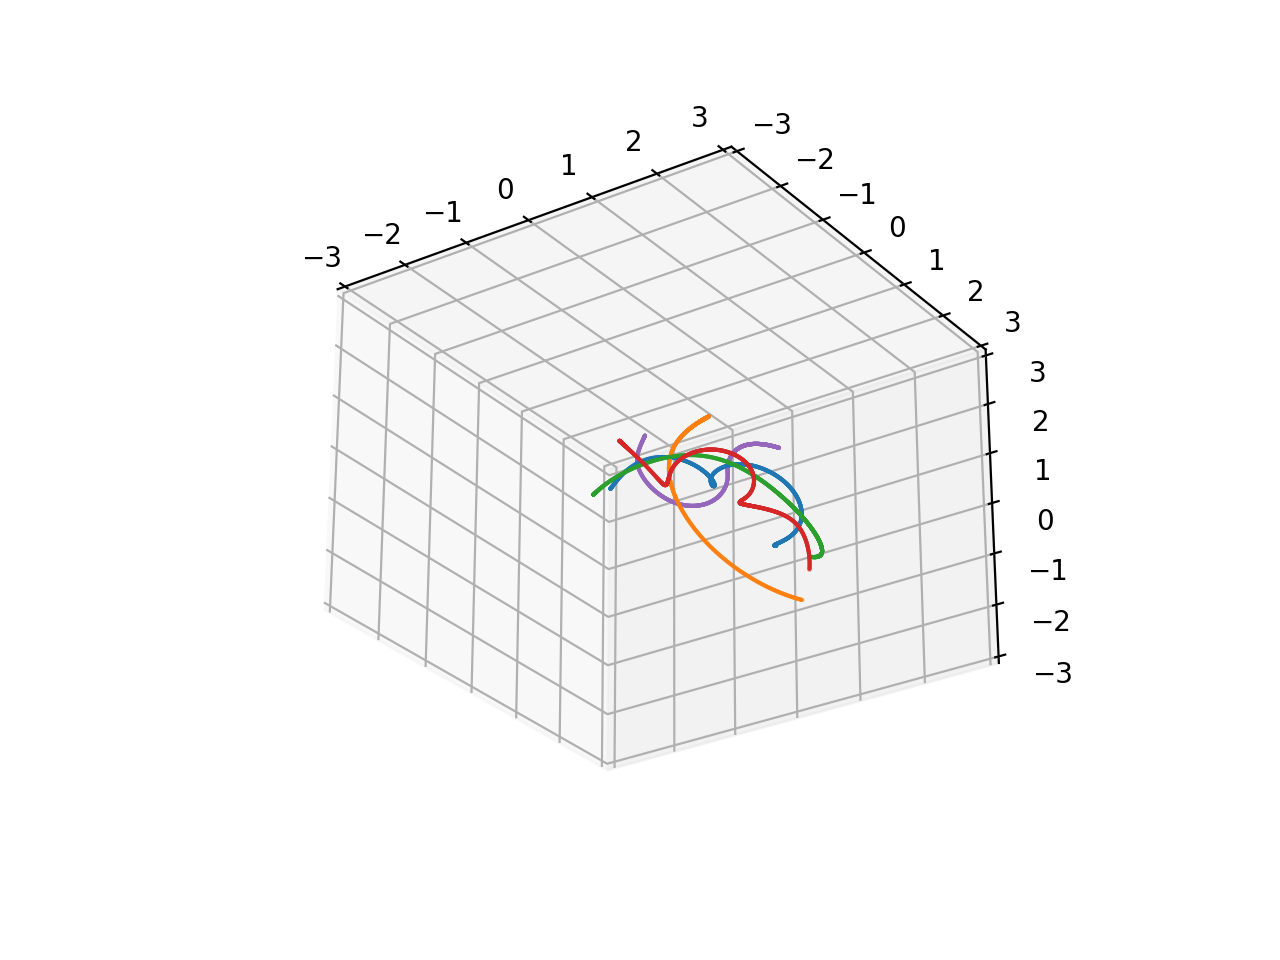

In [42]:
trajectory = main()
plot_trajectories(trajectory)

# Below is Testing

In [51]:
# Testing 1 Body
bodies = []
for i in range(3):
    j = np.random.rand(5)
    bodies.append(Body(j[0],j[1],j[2],j[3],j[4]))

root = Node(0,1,0,1)
for body in bodies:
    root.add_body(body)



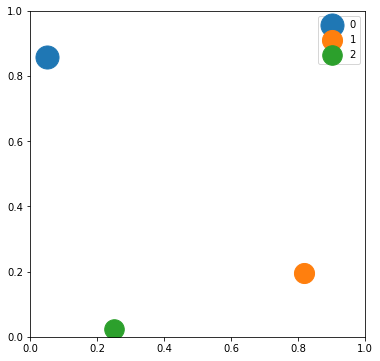

In [65]:
plt.figure(figsize = (6,6))
plt.xlim((0,1))
plt.ylim((0,1))
for i,body in enumerate(bodies):
    plt.scatter(body.px, body.py,label = i, s = 1000*body.mass)
plt.legend()

In [35]:
lesum = 0
totmass = 0
for body in bodies:
    lesum += body.mass*body.py
    totmass += body.mass
lesum /= totmass
print(totmass)
root.totM

1.0674262792162317


1.0674262792162317

In [67]:
root.calculate_force(root.botright.body)

In [70]:
print(root.botright.body.vx)
print(root.botright.body.fy)

0.14352285589777447
0.8066593624737919


In [ ]:
self.topleft, self.topright, self.botleft, self.botright = None, None, None, None
        
        # Define the Center of Mass and total Mass
        

In [ ]:
        self.topleft, self.topright, self.botleft, self.botright = None, None, None, None
        self.xleft, self.xright, self.ybot, self.ytop = xleft, xright, ybot, ytop
        self.centerx = (xleft+xright)/2
        self.centery = (ybot+ytop)/2
        
        # Define the Center of Mass and total Mass
        self.CoMx, self.CoMy, self.totM = None, None, 0
        
        # Define
        self.body = None
        